In [1]:
import pandas as pd
import numpy as np
import os, re
import matplotlib.pyplot as plt
%matplotlib inline

PATH2RAW = './raw_data'

## 1. Raw data: config & data files

Each observation is represented byof pair of files: 

* **measurement file** `.dat` - e.g.:  `16.03.2019-18.37.32.dat`

|  | Time | T_set1 | T_set2 | T_set_3 | T_set4 | N_cycle | Phase | T1 | R1 | T2 | R2 | T3 | R3 | T4 | R4 | 
| :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- |
| 0 | 0.26 | 100.0 | 150.0 | 150.0 | 150.0 | 1 | 3 | 6.796659 | 1017631.0 | 16.99999 | 3738238.0 | 13.96551 | 364169200.0 | 16.15645 | 138198600.0 |
| 1 | 0.37 | 100.0 | 150.0 | 150.0 | 150.0 | 1 | 3 | 9.633535 | 918182.3 | 21.88888 | 3400904.0 | 19.02298 | 247933100.0 | 20.91836 | 86560560.0 |

- `Time`: time in seconds from start of the experiment (sampling rate ~0.1sec);
- `T_set*`: temperature (Celsius) set by the heater control program, `*` - sensor number (1-4)
- `N_cycle`: the number of measurement period (each cycle ~60sec long; consists of phases 3-4-5-6)
- `Phases`: heater operating modes:
    - 3 - stable-bottom; 
    - 4 - heating;
    - 5 - stable-top;
    - 6 - cooling;
- `T*`: observed temperature (Celsius) `*` - sensor number (1-4);
- `R*`: observed sensor resistance `*` - sensor number (1-4);



* **config file** `.xlsx` - e.g.: `16.03.2019-18.37.32.xlsx`

|  | time | gas | conc ppm |
| :- | :- | :- | :- |
| 0 | 0 | air | 0 |
| 1 | 3600 | H2 | 1600 |
| 2 | 7200 | air | 0 |
| 3 | 10800 | propane | 1600 |

- `time`: time in seconds from start of the experiment, 
>    Let's check an example: 
    * 0 row: `0 air 0` -  urban air (any addition gas concentration = 0ppm) was oberved during 0-3600sec from experiment starting
    * 1 row: `3600 H2 1600` - H2 at concentration 1600ppm was observed at 3600-7200sec
    * 2 row: `7200 air 0` - air was observed at 7200-10800sec
    * 3 row: `10800 propane 1600` - propane at concentration 1600ppm was oberved after 10800sec
 
    
- `gas`: observed gas;
- `conc ppm`: gas concentration parts per million.


In [3]:
# let's check configure file
config_file = pd.read_excel(os.path.join(PATH2RAW, '16.03.2019-18.37.32.xlsx'))
config_file

,time,gas,conc ppm
0,0,air,0
1,3600,H2,1600
2,7200,air,0
3,10800,propane,1600
4,14400,air,0
5,18000,h2,800
6,21600,air,0
7,25200,propane,800
8,28800,air,0
9,32400,h2,400


In [4]:
# let's check raw data file
data_file = pd.read_table(os.path.join(PATH2RAW, '16.03.2019-18.37.32.dat'), delimiter=r"\s+", decimal=',', skiprows=1)
data_file.iloc[:3,:]

,Time,T_set1,T_set2,T_set_3,T_set4,N_cycle,Phase,T1,R1,T2,R2,T3,R3,T4,R4
0,0.26,100.0,150.0,150.0,150.0,1,3,6.796659,1017631.0,16.99999,3738238.0,13.96551,364169200.0,16.15645,138198600.0
1,0.37,100.0,150.0,150.0,150.0,1,3,9.633535,918182.3,21.88888,3400904.0,19.02298,247933100.0,20.91836,86560560.0
2,0.47,100.0,150.0,150.0,150.0,1,3,12.234000,860797.7,26.11109,2986317.0,23.39079,161275500.0,25.45350,68144780.0


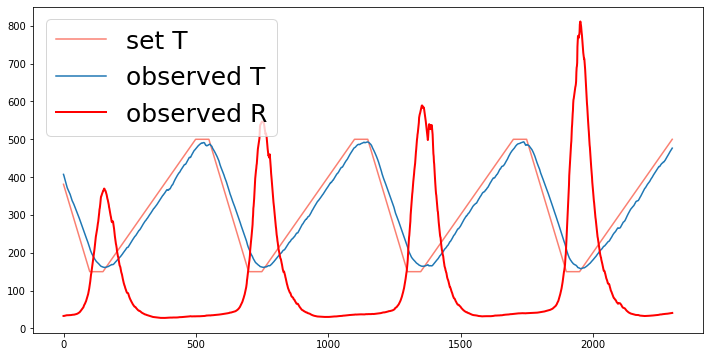

In [5]:
# let's visualize a observed:

fig, ax = plt.subplots()
ax.plot(np.array(data_file['T_set2'][500:2800]), label = 'set T', color='salmon')
ax.plot(np.array(data_file['T2'][500:2800]), label =  'observed T')
ax.plot(np.array(data_file['R2'][500:2800])/1000, label = 'observed R', linewidth=2.0, color='red')
ax.legend(fontsize = 25)
fig.set_figwidth(12)
fig.set_figheight(6)

## 2. Prepared data: R & T observations

Because our main goal - gas classification, we have prepared files where each cycle\period is presented as a separate samples.

You could find files in root folder `./cropped_data`. This folder consists of folders `air, h2, propane` with measurement files for corresponding gas. There are pairs of files (R & T) for each experiment session (config file row number):

Example:
> 2 of numerous files in `./cropped_data/h2/`:
>
> `16.03.2019_R1_1600_num2.csv` & `16.03.2019_T1_1600_num2.csv`
>
> filenames have information about:
> - `23.03.2019` - experiment date;
> - `R` - measurement type (`R` - resistance; `T` - temperatire (Celsius));
> - `1` - sensor number;
> - `1600` - gas concentration;
> - `num2` - row number at **config file** for these measurements subset (here = 2)

The structure of typical observation file (here `16.03.2019_R1_1600_num2.csv`):

|  | 0 | 1 | 2 | 3 | ... | 547 | 548 | 549 | 550 |
| :- | :- | :- | :- | :- | :- | :- | :- | :- | :- |
| 0 | 1600 | 17780.8 | 17669.34 | 17909.73 | ... | 12127.51 | 12351.3 | 12496.23 | 12587.69 |
| 1 | 1600 | 12458.27 | 12427.96 | 12451.9 | ... | 10438.04 | 10489.96 | 10574.12 | 10580.16 |
| 2 | 1600 | 10470.03 | 10603.79 | 10604.77 | ... | 9784.31 | 9763.056 | 9759.589 | 9591.474 |

* first column\row - just dummy indexes;
* **column index** `0` - **gas concentration** (here 1600ppm, as expected from filename);
* each row has **resistance** (temperature, if `T` at filename) values at **column indexes** `1-550` for current cycle\period;

In [13]:
# let't check root folder of prepared data
PATH2CROP = './cropped_data'
os.listdir(PATH2CROP)

['air', 'h2', 'propane']

In [12]:
os.listdir(os.path.join(PATH2CROP, 'h2'))[:5]

['18.03.2019_T4_1600_num2.csv',
 '03.04.2019_R1_30_num15.csv',
 '03.04.2019_R1_30_num21.csv',
 '03.04.2019_R1_30_num27.csv',
 '03.04.2019_R1_30_num3.csv']

In [21]:
# let's explore resistance file:
R_data = pd.read_csv(os.path.join(PATH2CROP, 'h2', '16.03.2019_R1_1600_num2.csv'), index_col=0)

# and temperature file:
T_data = pd.read_csv(os.path.join(PATH2CROP, 'h2', '16.03.2019_T1_1600_num2.csv'), index_col=0)

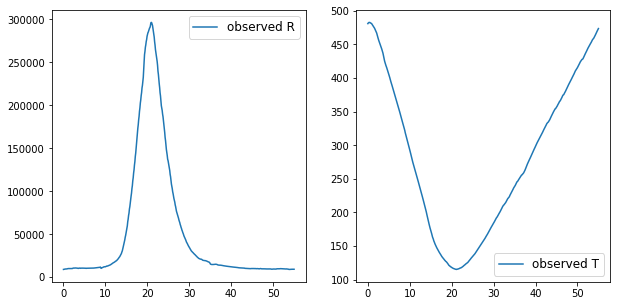

In [30]:
fig, axes = plt.subplots(1, 2)

x = np.linspace(0, 55, 550)
y = [R_data.iloc[10,1:], T_data.iloc[10,1:]]
y_label = ['observed R', 'observed T']

for ax in range(2):
    axes[ax].plot(x, y[ax], label = y_label[ax])
    axes[ax].legend(fontsize=12)

fig.set_figheight(5)
fig.set_figwidth(10)
plt.show()